ARIMA


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import seaborn as sns # Visualization
import matplotlib.pyplot as plt # Visualization

from statsmodels.tsa.statespace.sarimax import SARIMAX


from sklearn.metrics import mean_absolute_error, mean_squared_error
import math

import warnings # Supress warnings
warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Rain Prediction/rainfall_dataset.csv")

In [ ]:
df.shape

(14608, 6)

In [ ]:
df.head()

,date_time,rainfall,relative_humidity,temperature,wind_speed_SP,wind_speed_DR
0,2018-01-01 00:00:00,0.0,98,16.5,2,8
1,2018-01-01 03:00:00,0.0,74,19.2,3,9
2,2018-01-01 06:00:00,0.0,57,25.7,3,12
3,2018-01-01 09:00:00,0.0,58,26.2,4,13
4,2018-01-01 12:00:00,0.0,77,23.0,0,0


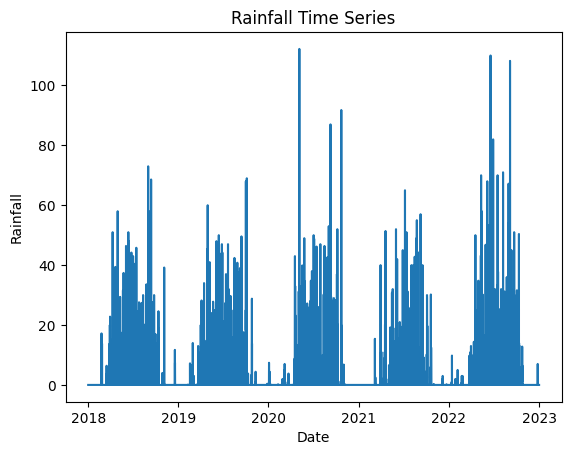

In [ ]:
# Preprocess the data
df['date_time'] = pd.to_datetime(df['date_time'])
df['rainfall'] = pd.to_numeric(df['rainfall'], errors='coerce')

# Set the date_time column as the index
df.set_index('date_time', inplace=True)

# Explore the data
plt.plot(df.index, df['rainfall'])
plt.xlabel('Date')
plt.ylabel('Rainfall')
plt.title('Rainfall Time Series')
plt.show()

# Split the dataset into training and testing sets
train_size = int(len(df) * 0.8)
train_data = df.iloc[:train_size]
test_data = df.iloc[train_size:]

# Define the parameter combinations for grid search
orders = [(1, 1, 1), (1, 1, 2), (2, 1, 1)]
seasonal_orders = [(1, 1, 1, 24), (1, 1, 2, 24), (2, 1, 1, 24)]

In [ ]:
from joblib import Parallel, delayed

def evaluate_model(order, seasonal_order, train_data, test_data):
    try:
        # Build the SARIMAX model
        model = SARIMAX(train_data['rainfall'], order=order, seasonal_order=seasonal_order)
        model_fit = model.fit(disp=False)

        # Validate the model
        predictions = model_fit.predict(start=test_data.index[0], end=test_data.index[-1])
        mse = np.mean((predictions - test_data['rainfall']) ** 2)
        rmse = np.sqrt(mse)

        return rmse, order, seasonal_order

    except:
        return float('inf'), order, seasonal_order

# Perform parallel processing for grid search
results = Parallel(n_jobs=-1)(
    delayed(evaluate_model)(order, seasonal_order, train_data, test_data)
    for order in orders
    for seasonal_order in seasonal_orders
)

# Find the best parameters
best_rmse = float('inf')
best_order = None
best_seasonal_order = None

for rmse, order, seasonal_order in results:
    if rmse < best_rmse:
        best_rmse = rmse
        best_order = order
        best_seasonal_order = seasonal_order

print("Best Parameters:")
print("Order:", best_order)
print("Seasonal Order:", best_seasonal_order)

Best Parameters:
Order: (1, 1, 2)
Seasonal Order: (1, 1, 2, 24)


Root Mean Squared Error (RMSE): 7.315698088838123
Forecasted Rainfall:
2021-12-31 18:00:00    0.001041
2021-12-31 21:00:00    1.021198
2022-01-01 00:00:00    1.177485
2022-01-01 03:00:00    0.532376
2022-01-01 06:00:00   -0.030385
2022-01-01 09:00:00   -0.580787
2022-01-01 12:00:00   -0.370128
2022-01-01 15:00:00   -0.550866
2022-01-01 18:00:00   -0.265033
2022-01-01 21:00:00    0.853506
Freq: 3H, Name: predicted_mean, dtype: float64


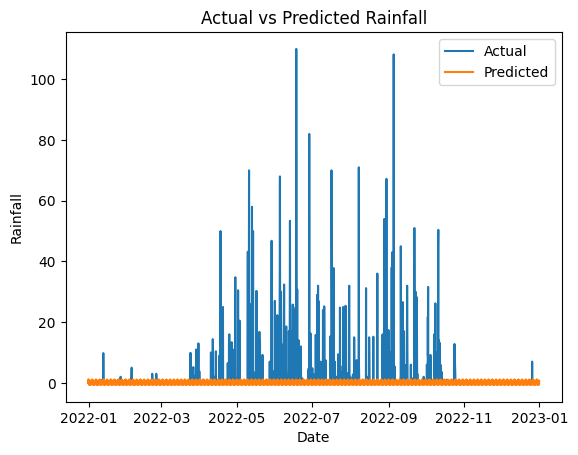

In [ ]:
# Build the SARIMAX model with optimal parameters
model = SARIMAX(train_data['rainfall'], order=best_order, seasonal_order=best_seasonal_order)
model_fit = model.fit(disp=False)

# Validate the model
predictions = model_fit.predict(start=test_data.index[0], end=test_data.index[-1])
mse = np.mean((predictions - test_data['rainfall']) ** 2)
rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse)

# Forecast future rainfall
forecast_steps = 10
forecast = model_fit.forecast(steps=forecast_steps)
print("Forecasted Rainfall:")
print(forecast)

# Plot the predicted values
plt.plot(test_data.index, test_data['rainfall'], label='Actual')
plt.plot(test_data.index, predictions, label='Predicted')
plt.xlabel('Date')
plt.ylabel('Rainfall')
plt.title('Actual vs Predicted Rainfall')
plt.legend()
plt.show()

In [ ]:
df.shape

(14608, 5)

So there is no missing values

In [ ]:
# df.index.freq = '3H'

In [ ]:
df.head()

,rainfall,relative_humidity,temperature,wind_speed_SP,wind_speed_DR
date_time,,,,,
2018-01-01 00:00:00,0.0,98,16.5,2,8
2018-01-01 03:00:00,0.0,74,19.2,3,9
2018-01-01 06:00:00,0.0,57,25.7,3,12
2018-01-01 09:00:00,0.0,58,26.2,4,13
2018-01-01 12:00:00,0.0,77,23.0,0,0


In [ ]:
df = pd.DataFrame(df['rainfall'])

<Axes: xlabel='date_time'>

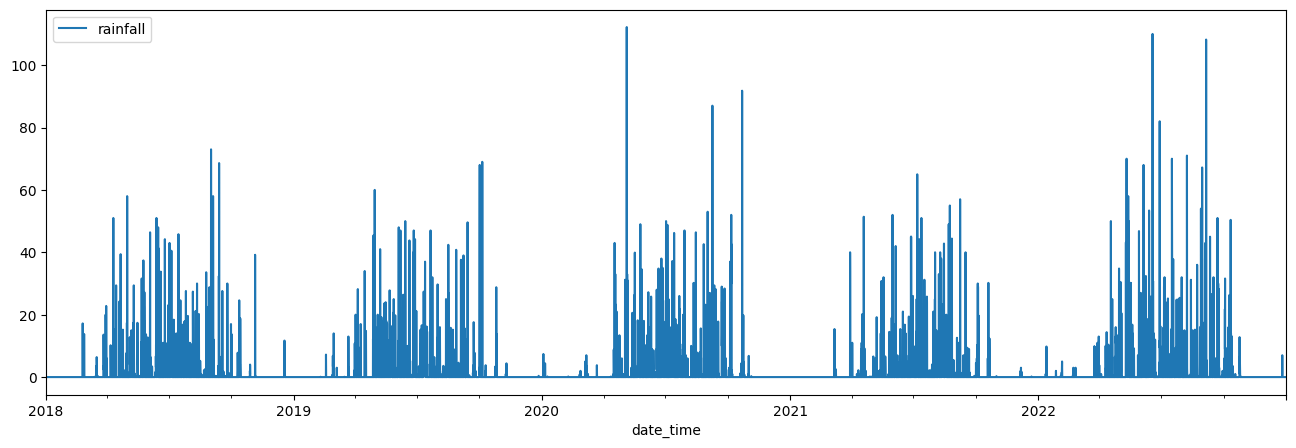

In [ ]:
df.plot(figsize=(16,5))

In [ ]:
train = df.iloc[:10226,0]
test = df.iloc[10226:,0]

# Check Stationarity

Method -1 : time series plot

Method - 2: ACF plot and PACF plot

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

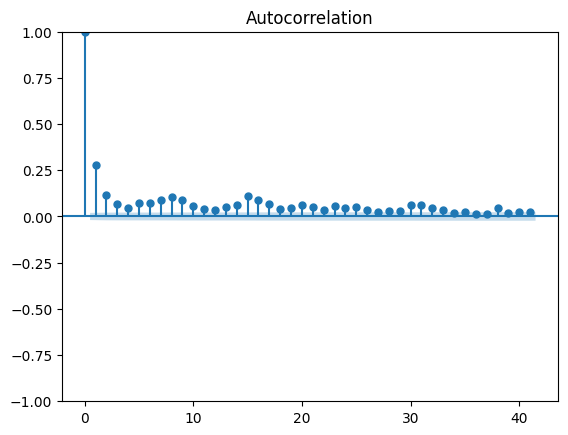

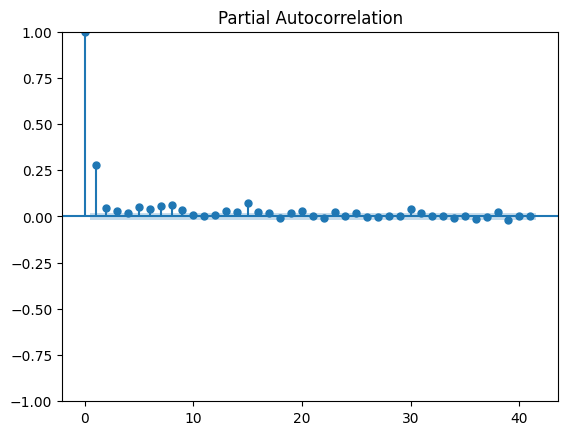

In [ ]:
acf_original = plot_acf(train)
pacf_original = plot_pacf(train)

Method -3 : ADF test


In [ ]:
from statsmodels.tsa.stattools import adfuller

adf_test = adfuller(train)

print(f'p - value: {adf_test[1]}')

p - value: 4.172948060751842e-24


As the model is stationary so the d value is : 1

From the plot we see the the p value will be: 0

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

ARIMA_Model = ARIMA(train, order= (2,1,1))

predictor = ARIMA_Model.fit()

predictor.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:               rainfall   No. Observations:                10226
Model:                 ARIMA(2, 1, 1)   Log Likelihood              -31274.249
Date:                Fri, 01 Sep 2023   AIC                          62556.499
Time:                        15:42:27   BIC                          62585.429
Sample:                    01-01-2018   HQIC                         62566.281
                         - 07-02-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2384      0.004     60.900      0.000       0.231       0.246
ar.L2          0.0158      0.006      2.593      0.010       0.004       0.028
ma.L1         -0.9915      0.001   -950.853      0.000      -0.994      -0.989
sigma2        26.5493      0.060    439.874      0.000      26.431      26.668
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):           2577302.34
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               1.51   Skew:                             7.13
Prob(H) (two-sided):                  0.00   Kurtosis:                        79.46
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

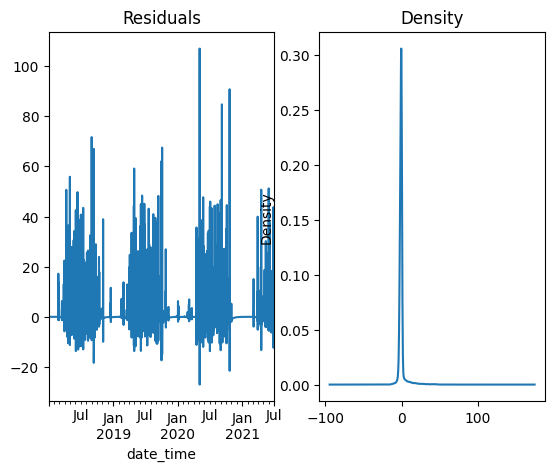

In [ ]:
residuals = predictor.resid[1:]
fig, ax = plt.subplots(1,2)

residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(title="Density", kind='kde', ax=ax[1])
plt.show()

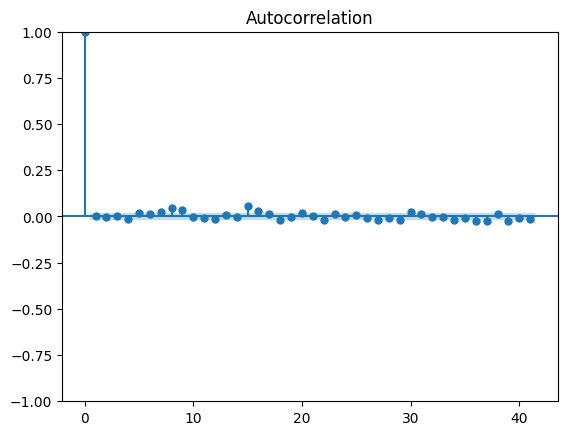

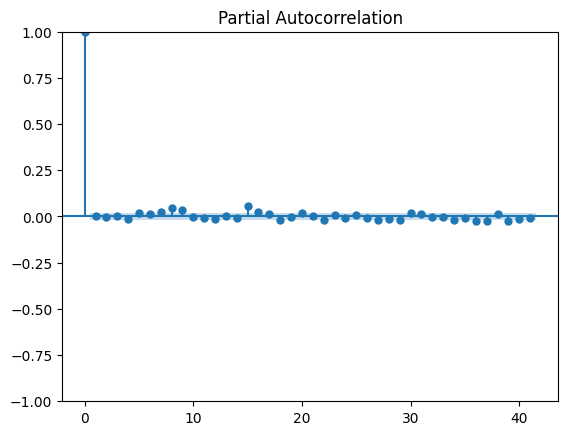

In [ ]:
acf_res = plot_acf(residuals)
pacf_res = plot_pacf(residuals)

<Axes: xlabel='date_time'>

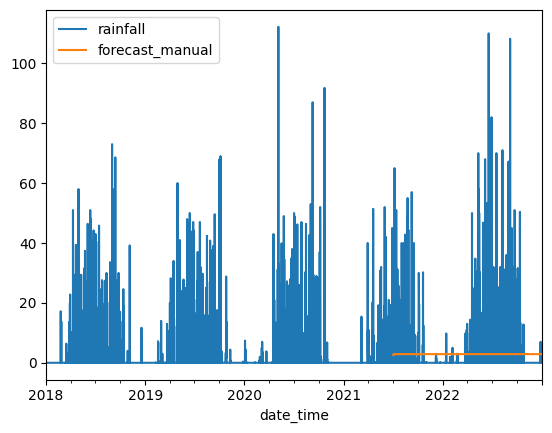

In [ ]:
forecast_test = predictor.forecast(len(test-1))
df['forecast_manual'] = [None]*len(train) + list(forecast_test)
df.plot()

In [ ]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 9.5 MB/s eta 0:00:00


In [ ]:
from pmdarima import auto_arima
import pmdarima as pm

In [ ]:
auto_arima = pm.auto_arima(train, stepwise=False, seasonal=False)
auto_arima

ARIMA(order=(1, 0, 2), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [ ]:
auto_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                10226
Model:               SARIMAX(1, 0, 2)   Log Likelihood              -31299.162
Date:                Fri, 01 Sep 2023   AIC                          62606.325
Time:                        15:24:32   BIC                          62635.255
Sample:                    01-01-2018   HQIC                         62616.107
                         - 07-02-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9992      0.001   1875.480      0.000       0.998       1.000
ma.L1         -0.7653      0.004   -192.563      0.000      -0.773      -0.758
ma.L2         -0.2205      0.004    -54.250      0.000      -0.228      -0.212
sigma2        26.6682      0.084    319.187      0.000      26.504      26.832
===================================================================================
Ljung-Box (L1) (Q):                   1.97   Jarque-Bera (JB):           2579171.18
Prob(Q):                              0.16   Prob(JB):                         0.00
Heteroskedasticity (H):               1.52   Skew:                             7.18
Prob(H) (two-sided):                  0.00   Kurtosis:                        79.47
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<Axes: xlabel='date_time'>

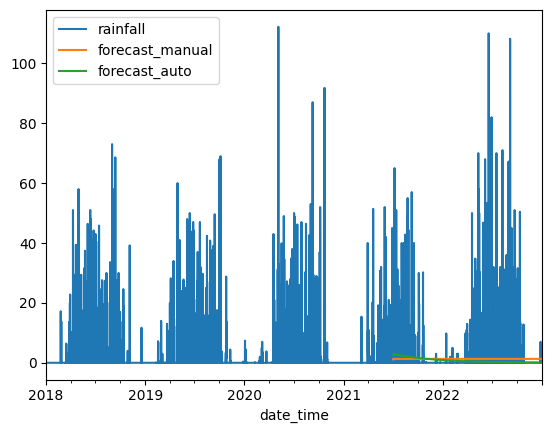

In [ ]:
forecast_auto_test = auto_arima.predict(n_periods=len(test))
df['forecast_auto'] = [None]*len(train) + list(forecast_auto_test)

df.plot()

In [ ]:
#Devloping

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

In [ ]:
ARIMA_Model = ARIMA(train, order= (0,1,3))

In [ ]:
predictor = ARIMA_Model.fit()

In [ ]:
predictor.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:               rainfall   No. Observations:                13148
Model:                 ARIMA(0, 1, 3)   Log Likelihood              -40688.899
Date:                Sun, 23 Jul 2023   AIC                          81385.797
Time:                        16:55:12   BIC                          81415.733
Sample:                    01-01-2018   HQIC                         81395.794
                         - 07-02-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.7238      0.003   -238.921      0.000      -0.730      -0.718
ma.L2         -0.1825      0.006    -30.743      0.000      -0.194      -0.171
ma.L3         -0.0796      0.005    -15.370      0.000      -0.090      -0.069
sigma2        28.5508      0.061    471.231      0.000      28.432      28.670
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):           2937479.89
Prob(Q):                              0.78   Prob(JB):                         0.00
Heteroskedasticity (H):               1.11   Skew:                             6.90
Prob(H) (two-sided):                  0.00   Kurtosis:                        74.92
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
predicted_result = predictor.predict(start=len(train), end=len(train)+len(test)-1, type='levels')

In [ ]:
predicted_result

2022-07-02 12:00:00    3.265614
2022-07-02 15:00:00    4.133498
2022-07-02 18:00:00    4.396228
2022-07-02 21:00:00    4.396228
2022-07-03 00:00:00    4.396228
                         ...   
2022-12-31 09:00:00    4.396228
2022-12-31 12:00:00    4.396228
2022-12-31 15:00:00    4.396228
2022-12-31 18:00:00    4.396228
2022-12-31 21:00:00    4.396228
Freq: 3H, Name: predicted_mean, Length: 1460, dtype: float64

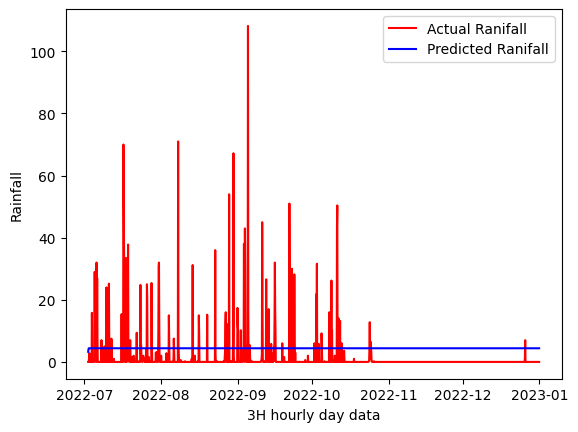

In [ ]:
plt.plot(test, color='red', label='Actual Ranifall')
plt.plot(predicted_result, color='blue', label='Predicted Ranifall')
plt.xlabel('3H hourly day data')
plt.ylabel('Rainfall')
plt.legend()
plt.show()

In [ ]:
test.mean()

1.5781506849315068

In [ ]:
predicted_result.mean()

4.395273385358984

In [ ]:
import math
from sklearn.metrics import mean_squared_error

In [ ]:
rmse = math.sqrt(mean_squared_error(test, predicted_result))

In [ ]:
rmse

7.541644402641995